In [1]:
#Imports
import time
import random
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.widgets import Cursor
from PIL import Image
import hashlib
get_ipython().run_line_magic('matplotlib', 'inline')
import dcor
import scipy

In [2]:
#Precision 
exp32 = 4294967296
# exp36 = 68719476735
#Iterations of Cascade
n = 20
def PL_PWLCM_IMPR(y0,p2):
    #(x-[x/q]*q)/q
    #With precision
    t2 =  math.floor(y0/p2)*p2
    t1 = exp32*(y0-t2)/p2
    return t1

diffRound = 1

# originalKey = 0x74cbb174cbb174cbb174cbb174cbb174cbb1
originalKey =   0x12d6870025ad0e01d32ec40096b438074cbb1
mKey1 =   0x0000000000000000000001000000001000000001
mKey2 =   0x0000000000000000000001000000001000000002
mKey3 =   0x0000000000000000000001000000001000000003
mKey4 =   0x0000000000000000000001000000001000000004

In [3]:
#Piecewise Lineaer Chaotic Map for y1,z1 from y0,z0,p1,p2
#recursive functions
def PL_PWLCM(y0,p2):
    y1=0
    if y0<p2:
        y1 = math.floor(exp32*y0/p2)
    elif p2<y0 and y0 < exp32/2:
        y1 = math.floor(exp32*(y0-p2)/(exp32/2 - p2))
    elif y0 == exp32/2 :
        y1 = 0
    else:
        y1 = PL_PWLCM(exp32-y0, p2)
    return y1

#Logistic Map for x1 from x0
def PL_Logistic(x0):
    x1 = math.floor(4*x0*(exp32-x0)/exp32)
    return x1

def PWLCM_Init(x0,y0,p1,p2):
    x1 = x0
    y1 = y0
    for i in range(n):
        x1 = PL_PWLCM(x1,p1)
        y1 = PL_PWLCM(y1,p2)
    return x1,y1

def Logistic_Init(x0):
    x1 = x0
    for i in range(n):
        x1 = PL_Logistic(x1)
    return x1


In [4]:
# Initialization
def getParas(key):
    p2 = key & 0x7fffffff #31 bits
    z0 = (key>>31) & 0x7fffffff #31 bits
    p1 = (key>>62) & 0x7fffffff #31 bits
    y0 = (key>>93) & 0x7fffffff #31 bits
    x0 = (key>>124) & 0xffffffff #32 bits
    x0,y0,z0 = InitPRNG(x0,y0,p1,z0,p2)    
    return x0,y0,p1,z0,p2


def InitPRNG(x0,y0,p1,z0,p2):
    x1 = x0
    y1 = y0
    z1 = z0
    
    for i in range(n):
        y1,z1 = PWLCM_Init(y1,z1,p1,p2)
        x1 = Logistic_Init(x1)
    return x1,y1,z1

#32 bit r1
def PL_PWLCM_Logistic(x0,y0,p1,z0,p2):
    
    y1 = PL_PWLCM(y0,p1)
    z1 = PL_PWLCM(z0,p2)
    x1 = PL_Logistic(x0)
    temp1 = x1 ^ y1
    r1 = (temp1 + z1) % exp32
    return x1,y1,z1,r1


In [5]:
#For Pure Logistic Map Random Numbers


#32 bit r1
def PL_Logistic_PURE(x0):
    
    x1 = x0
    y1 = 0
    z1 = 0
    x1 = PL_Logistic(x1)
    #temp1 = x1 ^ y1
    r1 = x1
    return x1,y1,z1,r1


In [6]:
#For Pure Logistic Map Random Numbers
# Initialization


#32 bit r1
def PL_PWLCM_PURE(y,p):
    y1 = y
    y1 = PL_PWLCM(y1,p) %exp32
    
    return y1


In [7]:
# get the second column
def takeSecond(elem):
    return elem[1]


#key generation v2 output : PRNGlist, 32-Bit sorted sorting index 
def getPRNGEncryption(a,b,c,x0,y0,p1,z0,p2):
    
    #a,b,c are dimensions equivalent to w,h*d,1
    
    #iLen is when we divide the number of pixels by 4. (Number of 4-pixeled units)
    iLen = math.ceil(a*b*c/4)
    
    # if the a and c are not the interal multiple of 2, discard the last row and column  
    sortLength = (a//2)*(b//2)*c 
    
    
    PermutationList = list();
    DiffusionList = np.zeros(a*b*c, dtype = np.int, order = 'C')
    
    time_start=time.time()
    
    for iNum in range(iLen):
        
        x0,y0,z0,res = PL_PWLCM_Logistic(x0,y0,p1,z0,p2)
        
        if iNum < sortLength:
            PermutationList.append([iNum,res])
            
        if (iNum+1)*4 <= a*b*c:
            DiffusionList[iNum*4] = (res >> 24) & 0xff
            DiffusionList[iNum*4+1] = (res >> 16) & 0x00ff
            DiffusionList[iNum*4+2] = (res >> 8) & 0x0000ff
            DiffusionList[iNum*4+3] = (res >> 0) & 0x000000ff
       
        else:
            tail = a*b*c % 4
            shiftUnit = [0xff,0x00ff,0x0000ff,0x000000ff]
            for i in range(tail):
                DiffusionList[iNum*4+i] = (res >> 24-i*8) & shiftUnit[i]
        

        
    time_end=time.time()
    
    PermutationList.sort(key=takeSecond)
    
            
                        
    if c == 1: #gray
        return  PermutationList,DiffusionList.reshape(a,b),x0,y0,z0
    else:
        return PermutationList,DiffusionList.reshape(a,b,c),x0,y0,z0


def getPRNGDecryption(a,b,c,y,p):
    
    #a,b,c are dimensions equivalent to w,h*d,1
    
    #iLen is when we divide the number of pixels by 4. (Number of 4-pixeled units)
    iLen = math.ceil(a*b*c/4)
    
    # if the a and c are not the interal multiple of 2, discard the last row and column  
    sortLength = (a//2)*(b//2)*c 
    
    
    PermutationList = list();
    DiffusionList = np.zeros(a*b*c, dtype = np.int, order = 'C')
    
    time_start=time.time()
    
    for iNum in range(iLen):
        
        y = PL_PWLCM_PURE(y,p)
        res=y
        if iNum < sortLength:
            PermutationList.append([iNum,res])
            
        if (iNum+1)*4 <= a*b*c:
            DiffusionList[iNum*4] = (res >> 24) & 0xff
            DiffusionList[iNum*4+1] = (res >> 16) & 0x00ff
            DiffusionList[iNum*4+2] = (res >> 8) & 0x0000ff
            DiffusionList[iNum*4+3] = (res >> 0) & 0x000000ff
       
        else:
            tail = a*b*c % 4
            shiftUnit = [0xff,0x00ff,0x0000ff,0x000000ff]
            for i in range(tail):
                DiffusionList[iNum*4+i] = (res >> 24-i*8) & shiftUnit[i]
        

        
    time_end=time.time()
    
    PermutationList.sort(key=takeSecond)
    
            
                        
    if c == 1: #gray
        return  PermutationList,DiffusionList.reshape(a,b),0,y,0
    else:
        return PermutationList,DiffusionList.reshape(a,b,c),0,y,0



In [8]:
def Enc(img,permutationKey,ValueKey,scale):
   
    w,h = img.shape
    k =  permutationKey
    
    #confusion
    c =  np.zeros((w,h), dtype=np.int)
    c = img.copy()
    istep = h//2
   

    for i in range(len(k)):
          
            iRow = (k[i]//istep)*2
            iCol = (k[i] % istep)*2
            iRow0 = (i // istep)*2
            iCol0 = (i % istep)*2
            
            #4 units of a pixel
            c[iRow0,iCol0] = img[iRow,iCol]
            c[iRow0+1,iCol0] = img[iRow+1,iCol]
            c[iRow0,iCol0+1] = img[iRow,iCol+1]
            c[iRow0+1,iCol0+1] = img[iRow+1,iCol+1]

            
    b = np.zeros((w,h), dtype=np.int)
    b = c.copy()
    

    #Requires 2 rounds of diffusion
    for iwhole in range(diffRound):
    
        #step2.1 diffuse row
        #Start at index 0, till index w-1, with stepsize as 1
        for iRow in range(0,w,1):
            
            #If it is the first row
            if iRow == 0:
                #Take the current row, the last row, and correspoding row from the diffsion matrix and then scale
                b[iRow,:] = (b[-1,:] + b[iRow,:] + ValueKey[iRow,:]) % scale
            else:
                #Else, take the current and the previous row with the diffusion matrix row
                b[iRow,:] = (b[iRow-1,:] + b[iRow,:] + ValueKey[iRow,:]) % scale
        

        #step2.2 diffuse column
        for iCol in range(0,h,1):
            if iCol == 0:
                b[:, iCol] = (b[:, -1] + b[:, iCol] + ValueKey[:, iCol]) % scale
            else:
                b[:, iCol] = (b[:, iCol-1] + b[:, iCol] + ValueKey[:, iCol]) % scale


    return b


def doColorEnc(img,k):
    
    time_start=time.time()
    n = 1 # Encryption round
    w,h,d = img.shape #return row and column
    print(img.shape)
    img = img.reshape((w,h*d))
    
    for i in range(n):
        x0,y0,p1,z0,p2 = getParas(k)
        
        permutationList,diffusionArray,x0,y0,z0 = getPRNGEncryption(w,h*d,1,x0,y0,p1,z0,p2)
     
         
        
        arr = np.array(permutationList)
        #First column
        sortkey = arr[:,0]
        #Scale = 256, DiffRounds = 2
        img = Enc(img,sortkey,diffusionArray,256)
        
    img = img.reshape((w,h,d))
    time_end=time.time()
    print('Enc timev cost:',time_end-time_start,'s')
    
    return img



In [9]:

def Dec(a,SortKey,ValueKey,scale):
    
    #step1: de-confusion
    w,h = a.shape
    c =  np.zeros((w,h), dtype=np.int)
    c = a.copy()
    k = SortKey
    
    for iwhole in range(diffRound):
        for iCol in range(h-1,-1,-1):
            if iCol == 0:
                c[:, iCol] = (c[:, iCol] - c[:, -1] - ValueKey[:, iCol]) % scale
            else:
                c[:, iCol] = (c[:, iCol] - c[:, iCol-1] - ValueKey[:, iCol]) % scale
        for iRow in range(w-1,-1,-1):
            if iRow == 0:
                c[iRow,:] = (c[iRow,:] - c[-1,:] - ValueKey[iRow,:])% scale
            else:
                c[iRow,:] = (c[iRow,:] - c[iRow-1,:] - ValueKey[iRow,:])% scale 
    
    b =  np.zeros((w,h), dtype=np.int)
    b = c.copy()
    istep = h//2
    
    #k (Sort key is the index in sorted order)
    for i in range(len(k)):
          
            iRow = (k[i]//istep)*2
            iCol = (k[i] % istep)*2
            iRow0 = (i // istep)*2
            iCol0 = (i % istep)*2
            b[iRow,iCol] = c[iRow0,iCol0]
            b[iRow+1,iCol] = c[iRow0+1,iCol0]
            b[iRow,iCol+1] = c[iRow0,iCol0+1]
            b[iRow+1,iCol+1] = c[iRow0+1,iCol0+1]
    
    return b

#If we can the orignal image without key from cipher
#Can we obtain the key

def doColorDec(img,k):
    n = 1 # Decryption round    
    w,h,d = img.shape #return row and column
    img = img.reshape((w,h*d))
    
    tempY= 2453551650
    tempP= 1395574227

    
    for i in range(n-1,-1,-1):
        x0,y0,p1,z0,p2 = getParas(k)
#         permutationList,diffusionArr,x0,y0,z0 = getPRNGDecryption(w,h*d,1,tempY, tempP)
        permutationList,diffusionArr,x0,y0,z0 = getPRNGEncryption(w,h*d,1,x0,y0,p1,z0,p2)
        arr = np.array(permutationList)
        sortkey = arr[:,0]
        
        img = Dec(img,sortkey,diffusionArr,256)
    
    img = img.reshape((w,h,d))
    return img


In [10]:
#Can we decrypt without key?
#1. Uses statistical methods and findings to find the Average, Median and Mode of the Rn matrix and use that res value as
#   unit of diffusion and permutation
#n=20 Mean = 2155273622.607157  Median =  2167530229.5  Mode =  2167530229.5

# 288485633.45617676  


# 262146.0
# 514, 1026, 130, 258, 2050, 4098, 8194, 16386, 32770, 65538, 131074, 262146, 524290, 1048578, 2097154, 4194306, 8388610, 16777218, 33554434, 67108866, 134217730, 268435458, 536870914, 1073741826



mres = int(4289215965)
   
def decWithoutTest(a,SortKey,ValueKey,scale,diffRound=2):
    
    #step1: de-confusion
    w,h = a.shape
    c =  np.zeros((w,h,1), dtype=np.int)
    c = a.copy()
    k = SortKey
    
    print("Shape of a is",a.shape," And the shape of c is ", c.shape)
    
    for iwhole in range(diffRound):
        for iCol in range(h-1,-1,-1):
            if iCol == 0:
                c[:, iCol] = (c[:, iCol] - c[:, -1] - ValueKey[:, iCol]) % scale
            else:
                c[:, iCol] = (c[:, iCol] - c[:, iCol-1] - ValueKey[:, iCol]) % scale
        for iRow in range(w-1,-1,-1):
            if iRow == 0:
                c[iRow,:] = (c[iRow,:] - c[-1,:] - ValueKey[iRow,:])% scale
            else:
                c[iRow,:] = (c[iRow,:] - c[iRow-1,:] - ValueKey[iRow,:])% scale 
    
    b =  np.zeros((w,h), dtype=np.int)
    b = c.copy()
    istep = h//2
    
    
    for i in range(len(k)):
            iRow = (k[i]//istep)*2
            iCol = (k[i] % istep)*2
            iRow0 = (i // istep)*2
            iCol0 = (i % istep)*2
            b[iRow,iCol] = c[iRow0,iCol0]
            b[iRow+1,iCol] = c[iRow0+1,iCol0]
            b[iRow,iCol+1] = c[iRow0,iCol0+1]
            b[iRow+1,iCol+1] = c[iRow0+1,iCol0+1]
    
    return b

def getDiffusionMatrix(a,b,c):
    
    sizeP = math.ceil(a*b*c/4)
    
    print("Size p is ",sizeP)
    PermutationList = list()
    DiffusionList = np.zeros(a*b*c, dtype = np.int, order = 'C')
    
    for iNum in range(sizeP):
        
        if iNum < sizeP:
            #Add the Rn generated sortLenght times (Total/4 pixels)
            #This is the Sp matrix
            PermutationList.append([iNum,mres])
    
        #Split Rn into 4 *-bit numbers and put in the Sd (Diffusion matrix) 
        if (iNum+1)*4 <= a*b*c:
            DiffusionList[iNum*4] = (mres >> 24) & 0xff
            DiffusionList[iNum*4+1] = (mres >> 16) & 0x00ff
            DiffusionList[iNum*4+2] = (mres >> 8) & 0x0000ff
            DiffusionList[iNum*4+3] = (mres >> 0) & 0x000000ff
       
        #When it is not a multiple of 4, discard whatever is left
        else:
            tail = a*b*c % 4
            shiftUnit = [0xff,0x00ff,0x0000ff,0x000000ff]
            for i in range(tail):
                DiffusionList[iNum*4+i] = (mres >> 24-i*8) & shiftUnit[i]
    
    
    PermutationList.sort(key=takeSecond)

    if c == 1: #gray
        return  PermutationList,DiffusionList.reshape(a,b)
    else:
        return PermutationList,DiffusionList.reshape(a,b,c)

    
def decWithoutKeyTest1(img):
    n = 1
    w,h,d= img.shape
    img = img.reshape((w,h*d));    #d =3 for color
    
    
    #Let h*d = f
    #For decryption I need a permutation matrix of w*f/4 and for diffusion, the above matrix split in w*f units
    #Each unit of the permutation matrix is a 32 bit number. For the diffusion, each unit is split in 4 diffused unit. 
    #An approxiamation of Rn after tests
    for i in range(n-1,-1,-1):
    
        pKey, diffusionKey = getDiffusionMatrix(w,h*d,1)
        arr = np.array(pKey)
        sortKey = arr[:,0]
        #Scale = 256, DiffRounds = 2
        print("In test, diff bounds are and image shape ebfore", diffusionKey.shape, img.shape)
        img = decWithoutTest(img,sortKey,diffusionKey,256)
    
    img = img.reshape((w,h,d))
    
    return img



In [11]:
#Can we get the key?
  
    
def getRelationBetweenPlainCipherDiffusion(imgOrg, imgEnc,w,h):
    
    value = np.zeros([w,h], dtype=np.int, order = 'C')

    scale = 256
    
    for j in range(h-1,-1,-1):
            
            if j == 0:
                value[:,j] = (imgEnc[:,j] - imgOrg[:,j]-imgEnc[:,-1])%scale
                
            else:
                value[:,j] = (imgEnc[:,j] - imgOrg[:,j]-imgEnc[:,j-1])%scale
    
    for j in range(w-1,-1,-1):
            
            if j == 0:
                value[j,:] = (imgEnc[j,:] - imgOrg[j,:]-imgEnc[-1,:])%scale
                
            else:
                value[j,:] = (imgEnc[j,:] - imgOrg[j,:]-imgEnc[j-1,:])%scale
   

                        
    return value
    
    
def binaryToDecimal(n):
    return int(n,2)
  
def decimalToBinary(n):
    return '{0:08b}'.format(int(n))


def getPermutationMatrix(w,h,newValue):
    #This is of size w,h/4
    PermutationList = list();
    iLen = (w//2*h//2)
    newValue = newValue.flatten()
    
    
    for i in range(iLen):
        r = ""
        r = r + str(decimalToBinary(newValue[i*4]))+str(decimalToBinary(newValue[i*4+1]))+str(decimalToBinary(newValue[i*4+2]))+str(decimalToBinary(newValue[i*4+3])) 
        binDec = binaryToDecimal(r)
        PermutationList.append([i,binDec])
        
    
    PermutationList.sort(key=takeSecond)
    
    return PermutationList
    
    
    
def newDec(img,w,h,c,sortKey,newValue, scale):
    
    #Reshape
    img = img.reshape(w,h)
    diffRound = 1
    #Diffusion reverse
    c = img.copy()
    k = sortKey
    for iwhole in range(diffRound):
        for iCol in range(h-1,-1,-1):
            if iCol == 0:
                c[:, iCol] = (c[:, iCol] - c[:, -1] - newValue[:, iCol]) % scale
            else:
                c[:, iCol] = (c[:, iCol] - c[:, iCol-1] - newValue[:, iCol]) % scale
        
        

        for iRow in range(w-1,-1,-1):
            if iRow == 0:
                c[iRow,:] = (c[iRow,:] - c[-1,:] - newValue[iRow,:])% scale
            else:
                c[iRow,:] = (c[iRow,:] - c[iRow-1,:] - newValue[iRow,:])% scale 
    
    b =  np.zeros((w,h), dtype=np.int)
    b = c.copy()
    istep = h//2
    

    for i in range(len(k)):
            iRow = (k[i]//istep)*2
            iCol = (k[i] % istep)*2
            iRow0 = (i // istep)*2
            iCol0 = (i % istep)*2
            b[iRow,iCol] = c[iRow0,iCol0]
            b[iRow+1,iCol] = c[iRow0+1,iCol0]
            b[iRow,iCol+1] = c[iRow0,iCol0+1]
            b[iRow+1,iCol+1] = c[iRow0+1,iCol0+1]
    
    
    
    
    return b

    
    
    
    
    
def testWithPlainAndCipher(imgOrg, imgEnc):
    
    w1,h1,d1 = imgOrg.shape
    imgOrg = imgOrg.reshape((w1,h1*d1))
  
    w2,h2,d2 = imgEnc.shape
    imgEnc = imgEnc.reshape((w2,h2*d2))
  
    print("For org", str(imgOrg.shape), " For enc", str(imgEnc.shape))
    w = w1
    h = h1*d1
   
    newValue = getRelationBetweenPlainCipherDiffusion(imgOrg, imgEnc,w,h)
    #Reshape
    
    newPermutationList = getPermutationMatrix(w,h,newValue)
    
    #This is the new diffusion matrxi
    arr = np.array(newPermutationList)
    sortkey = arr[:,0]
    testedImage = imgEnc
    testedImage = newDec(testedImage,w,h,1,sortkey,newValue,256)
    
    #Write
    testedImage = testedImage.reshape((w2,h2,d2))
    
    cv2.imwrite("testDecryptWithPlainAndCipher.jpg", testedImage)
    
    return testedImage

In [12]:
#Histograms Analysis
def expectation(x,f):
    tatal = 0.0
    for i in range(f):
        tatal = tatal + x[i]
    E = tatal/n
    return E

def Variance(x,f):
    varValue = 0.0
    expValue = expectation(x,f)
    for i in range(f):
        varValue = varValue + math.pow(x[i]-expValue,2)
    return varValue/f

def getVariances(listIm):
    
    for imp in listIm:
        arr= imgP.flatten()
        varValue = Variance(arr,arr.size)
        print("Variance is ",str(varValue))
        
def histogram(listOfIm):
    icount = 0
    index = len(listOfIm)
    
    plt.figure(figsize=(26,9*index),dpi=100)
    plt.rcParams['axes.titlesize'] = 25
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    # key = [0x7833A013F4DB0018F4FB4031E9F680BC614A,0x7833A013F4DB0018F4FB4031E9F680BC614B]
    
    for imgP in listOfIm:
        
        arr= imgP.flatten()
        varValue = Variance(arr,arr.size)
        plt.subplot(index,2,2+icount*2)
        n, bins, patches = plt.hist(arr, bins=256, density=0, facecolor='gray', alpha=0.75)
        plt.title("Encrypted ")
        plt.xlabel('Gray Value')
        plt.ylabel('Distribution')
        print("Variance is ",str(varValue))
        icount += 1




In [13]:
#Correlation Analysis
from PIL import Image
from matplotlib.widgets import Cursor
import numpy as np
import matplotlib.pyplot as plt
import math

def expectation(x,nf):
    #print(x)
    tatal = 0.0
    for i in range(nf):
        tatal = tatal + x[i]
    E = tatal/nf
    #print(E)
    return E

def Variance(x,nf):
    varValue = 0.0
    eValue = expectation(x,nf)
    for i in range(nf):
        varValue = varValue + math.pow(x[i]-eValue,2)
    return varValue/nf

def cov(x,y,nf):
    covValue = 0.0
    expX = expectation(x,nf)
    expY = expectation(y,nf)
    for i in range(nf):
        covValue = covValue + (x[i] - expX)*(y[i]-expY)
    return covValue/nf

def corr_coefficient(x,y,nf):
    covValue = cov(x,y,nf)
    varX = Variance(x,nf)
    varY = Variance(y,nf)
    varX = math.sqrt( varX )
    varY = math.sqrt( varY )
    #print(covValue,varX,varY)
    return  covValue/(varX*varX)

def Correlation(img,img2,LineColor,itype):
    x0=[]
    x1=[]
    y0=[]
    y1=[]
    
    if itype == 'Horizontal':
        for a in range(128):
            for b in range(32):
                x0.append(img2[2*a][4*b])
                x1.append(img2[1+2*a][4*b])
                y0.append(img[2*a][4*b])
                y1.append(img[1+2*a][4*b])
    elif itype == 'Vertical':
        for a in range(32):
            for b in range(128):
                x0.append(img2[4*a][2*b])
                x1.append(img2[4*a][1+2*b])
                y0.append(img[4*a][2*b])
                y1.append(img[4*a][1+2*b])
    else:
        for a in range(128):
            for b in range(32):
                x0.append(img2[2*a][4*b])
                x1.append(img2[1+2*a][1+4*b])
                y0.append(img[2*a][4*b])
                y1.append(img[1+2*a][1+4*b])
    return x0,x1,y0,y1

def correlation(plain,cipher):
    r=plain
    r1=cipher
    x0,x1,y0,y1 = Correlation(r,r1,'gray','Horizontal')
    fig = plt.figure(figsize=(34,10),dpi=100)
    ax = fig.add_subplot(1,2,1, facecolor='#EBEBEB')
    ax.plot(y0, y1, '.',color='gray')
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    plt.title('Horizontal')
    plt.xlabel("x(m,n)")
    plt.ylabel("x(m,n+1)")
    # Set useblit=True on most backends for enhanced performance.
    cursor = Cursor(ax, useblit=True, color='red', linewidth=2)
    ax = fig.add_subplot(1,2,2, facecolor='#EBEBEB')
    ax.plot(x0, x1, '.',color='gray')
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    plt.title('Encrypted-Horizontal')
    plt.xlabel("x(m,n)")
    plt.ylabel("x(m,n+1)")
    # Set useblit=True on most backends for enhanced performance.
    cursor = Cursor(ax, useblit=True, color='gray', linewidth=2)
    return 0


In [14]:
import random

def entropy1936(img):
    tmp = np.zeros(256)
    val = 0
    k = 0
    res = 0
    icount = 0
    for i in range(len(img)):
        for j in range(len(img[i])):
            val = img[i][j]
            tmp[val] = float(tmp[val] + 1)
            k =  float(k + 1)
            icount = icount + 1
            if icount > 1936:
                break
        if icount > 1936:
            break
    #print("break point :", icount)
    for i in range(len(tmp)):
        tmp[i] = float(tmp[i] / k)
    for i in range(len(tmp)):
        if(tmp[i] == 0):
            res = res
        else:
            res = float(res - tmp[i] * (math.log(tmp[i]) / math.log(2.0)))
    return res

def get30Blocks(img):
    # k = 30 -> 5 X 6 = 30 and m = 1936 - > block size = 44*44
    a,b = img.shape
    widthLeft = a - 5*44
    if widthLeft < 2:
        widthBegin = 0
    else:
        widthBegin = random.randint(0, widthLeft-1)
    #print("width begin:", widthBegin)
    hightLeft = b - 6*44
    if hightLeft < 2:
        hightBegin = 0
    else:
        hightBegin = random.randint(0, hightLeft-1)
    #print("hight begin:", hightBegin)
    imgBlock = list()
    for i in range(5):
        m = widthBegin + 44*i
        for j in range(6):
            n= hightBegin + 44*j
            temp = img[m:m+44, n:n+44]
            #print("temp image block's shape:", temp.shape)
            imgBlock.append(temp)
    return imgBlock
             
def averagenum(num):
    nsum = 0
    for i in range(len(num)):
        nsum += num[i]
    return nsum / len(num)    
    
def LocalEntropy(cipher):
    
    #step1 select 30 disjoint image blocks
    print("cipher shape:", cipher.shape)
    a,b = cipher.shape


    cipherBlock = list()
    cipherBlock = get30Blocks(cipher)
    localEntropy = list()
    for i in range(len(cipherBlock)):
        temp = entropy1936(cipherBlock[i])
        #print("local entropy: ", temp)
        localEntropy.append(temp)
    return averagenum(localEntropy)

In [15]:
#Differential Cryptanalysis
#For n images we wull havce nC2 pairs
def getPearsonCoefficients(listOrg, listEnc):
    
    mSize = len(listOrg)
    
    for i in range(mSize):
        for j in range(256):
            
            p = np.corrcoef(listOrg[i][:,j], listEnc[i][:,j])
            print('Pearson Relation for i=',i, 'is =',p)
    
    
def getDifferential(listOrg, listEnc,w,h,d):
    
    mSize = len(listOrg)
    path = "./TestDifferentials/"
    
    diffOrg = list()
    diffEnc = list()
    
    coefList = list() #Pearson
    distanceCorr = list() #Non lin
    statList = list() #Fisher result

    for i in range(mSize-1):
        for j in range(i+1,mSize,1):
            d1 = listOrg[i]-listOrg[j]
            d2 = listEnc[i]-listEnc[j]
            
            #Get the different for the pair 
            diffOrg.append(d1.flatten())
            diffEnc.append(d2.flatten())
            
#             cv2.imwrite(path+"_org_"+str(i)+"_"+str(j)+".jpeg",d1)
#             cv2.imwrite(path+"_enc_"+str(i)+"_"+str(j)+".jpeg",d2)
           
            coeff = corr_coefficient(d1.flatten(),d2.flatten(),w*h)
            disCorr = distanceCorrelation(d1.flatten(),d2.flatten())
            fisher = statisticalSignificance(pow(coeff,2),w,h,i,j)
            
            if fisher == 1:
                #Then there is a rel
                print('The Pearson coefficient is ', coeff)
                
                
            coefList.append(pow(coeff,2))
            distanceCorr.append(disCorr)
            statList.append(fisher)
            
            
            
    #            t1 = d1.flatten()
#             t2 = d2.flatten()
#             x = t1
#             y = t2
#             colors = (0,0,0)
#             area = np.pi*3

#             #     Plot
#             plt.scatter(x, y, s=area, c=colors, alpha=0.5)
#             plt.title('Scatter plot: ' +str(i)+"_"+str(j))
#             plt.xlabel('Original')
#             plt.ylabel('Enc')
#             plt.savefig(path+"_plot_"+str(i)+"_"+str(j)+".jpeg")
    
    plt.figure(figsize=(14,6))
    histogram_blue = distanceCorr
    
    plt.plot(histogram_blue, color='blue') 
   
    
#     getPearsonCoefficients(diffOrg,diffEnc)

#     #Plot this

def statisticalSignificance(coef,w,h,i,j):
    
    #coef = Pearson coef = r
    r = coef
    
    #r = Pearson Coefficient
    z = math.atanh(r)
    SD_z = 1 / math.sqrt(w*h - 3)
    z_upper = z + 1.96 * SD_z
    z_lower = z - 1.96 * SD_z
    r_upper = math.tanh(z_upper)
    r_lower = math.tanh(z_lower)
    
    #If r_upper and r_lower lie on the same side of zero, there there exists a statistical significance
    if r_upper*r_lower > 0:
        print('Statistical Significance found for image pairs ', i,',',j)
        return 1
    
    else:
        return 0
    
    
def distanceCorrelation(u,v):
    
#     d = dcor.distance_correlation(a,b)
#     print('Distance Correlation = ', d)
   
    d = scipy.spatial.distance.correlation(u, v, w=None, centered=True)
    return d
    
def doDifferntialTest(w,h,d):
    path = "./TestImages/"
    pictures = os.listdir(path)
    
    listOrg = list()
    listEnc = list()
    
    for picName in pictures:
        picPath = path + picName
        org_img = cv2.imread(picPath)
        enc_img = doColorEnc(org_img, originalKey)
        listOrg.append(org_img)
        listEnc.append(enc_img)
        
    getDifferential(listOrg, listEnc,w,h,d)
        
        

In [16]:
#Do CipherTextAttacK
def doCipherTextAttack(img,w,h):
    
    path = "./TestCipherText/"
    
    keyList = [0x74cbb174cbb174cbb174cbb174cbb174cbb1,
               0x74cbb174cbb174cbb174cbb174cbb174cbb2,
               0x74cbb174cbb174cbb174cbb174cbb174cbb3,
               0x74cbb174cbb174cbb174cbb174cbb174cbb4,
               0x14cbb174cbb174cbb174cbb174cbb174cbb1,
               0x143bb174cbb174cbb174cbb174cbb174cbb1,
               0x12d6870025ad0e01d32ec40096b438074cbb1,
               0x23d6870025ad0e01d32ec40096b438074cbb1,
               0x22d6870025ad0e01d32ec40096b438074cbb1,
               0x12d6870025ad0e01d32ec40096b438074cbb2,
               0x12d6870025ad0e01d32ec40096b438074cbb3,
               0x12d6870025ad0e01d32ec40096b438074cbb4,
               0x0000000000000000000001000000001000000001,
               0x0000000000000000000001000000001000000010]
    
    encList = list()
    
    for i in range(len(keyList)):
        encImg = doColorEnc(img,keyList[i])
        encList.append(encImg)
        cv2.imwrite(path+'key_'+str(i)+'_.jpeg', encImg)
    
    
    #Do corr_analysis for all
    mSize = len(encList)
    coefList = list()
    varList = list()
    
    disList = list()
    entropyList = list()
    
    for i in range(mSize-1):
        for j in range(i+1,mSize,1):
            
            d1 = encList[i]
            d2 = encList[j]
            
            
#             coeff = corr_coefficient(d1.flatten(),d2.flatten(),w*h)
#             coefList.append(coeff)
            
            #PairWise XOR
            xorValue = d1^d2
#             cv2.imwrite(path+ 'XOR_PAIR'+str(i)+'_'+str(j)+'_.jpeg', xorValue)
#             print('Xo Val is ', xorValue.shape)
                   
#             coeff = corr_coefficient(img.flatten(),xorValue.flatten(),w*h)
#             coefList.append(pow(coeff,2))
     
#             dis = distanceCorrelation(img.flatten(),xorValue.flatten())
#             disList.append(dis)
            
            
            xorValue = xorValue.reshape((w,h*d))
            ltropy = LocalEntropy(xorValue)
            entropyList.append(ltropy)
        
        
    plt.figure(figsize=(14,6)) 
    histogram_blue = entropyList
    plt.plot(histogram_blue, color='blue')
    
#     histogram_red = coefList
#     plt.plot(histogram_red, color='red')
   
    
def shannonEntropy(img):
    
    marg = np.histogramdd(np.ravel(img), bins = 256)[0]/img.size
    marg = list(filter(lambda p: p > 0, np.ravel(marg)))
    entropy = -np.sum(np.multiply(marg, np.log2(marg)))
    return entropy
 

def autumnSimilarImageTest():
    path = "./AutumnTest/"
    pictures = os.listdir(path)
    listEnc = list()
    
    keyList = [mKey1,mKey2,mKey3,mKey4]
    i=0
    for picName in pictures:
        picPath = path + picName
        org_img = cv2.imread(picPath)
        enc_img = doColorEnc(org_img, keyList[i])
        i= i+1
        #Find entropt
        entropyOr = shannonEntropy(org_img)
        entropyEn = shannonEntropy(enc_img)
        print(picName+': '+str(((entropyEn-entropyOr)/entropyOr) *100))
        
        cv2.imwrite('_dec'+path+picName+'.jpg',enc_img)
        listEnc.append(enc_img)
    
    
    w,h,d = listEnc[0].shape
    
    drawCorrelationChartForEncryptedImages(listEnc,w,h)
    
def drawCorrelationChartForEncryptedImages(listEnc,w,h):
    
    #Get the correlations
    mSize = len(listEnc)
    coefList = list()
    disList = list()
    
    for i in range(mSize-1):
        for j in range(i+1, mSize, 1):
            
            d1 = listEnc[i]
            d2 = listEnc[j]
            corr = corr_coefficient(d1.flatten(), d2.flatten(),w*h)
            coefList.append(pow(corr,2))
            
            dis = distanceCorrelation(d1.flatten(), d2.flatten())
            disList.append(dis)
        
    
    total = int((mSize*(mSize-1))/2)
    numList = range(1,total+1,1) 
    plt.figure(figsize=(14,6)) 
    histogram_blue = coefList
    histogram_red = disList
    
    plt.scatter(numList, coefList, color='blue', label = 'Pearson Coefficient')
    plt.scatter(numList, disList, color='red', label = 'Distance Coefficient')
    plt.legend(loc="lower right")
    plt.show()
        

(256, 256, 3)
Enc timev cost: 1.9379456043243408 s
Variance is  2951.6775443117003
Variance is  5469.630315105306
Variance is  2951.6775443117003
Correlation of encrypted -0.002555126682647107
Distance Coefficient of encrypted 0.9972582663799644
Correlation of decrypted 1.0
Distance Coefficient of decrypted 0.0
7.426956737962509
7.998936085692369
7.426956737962509


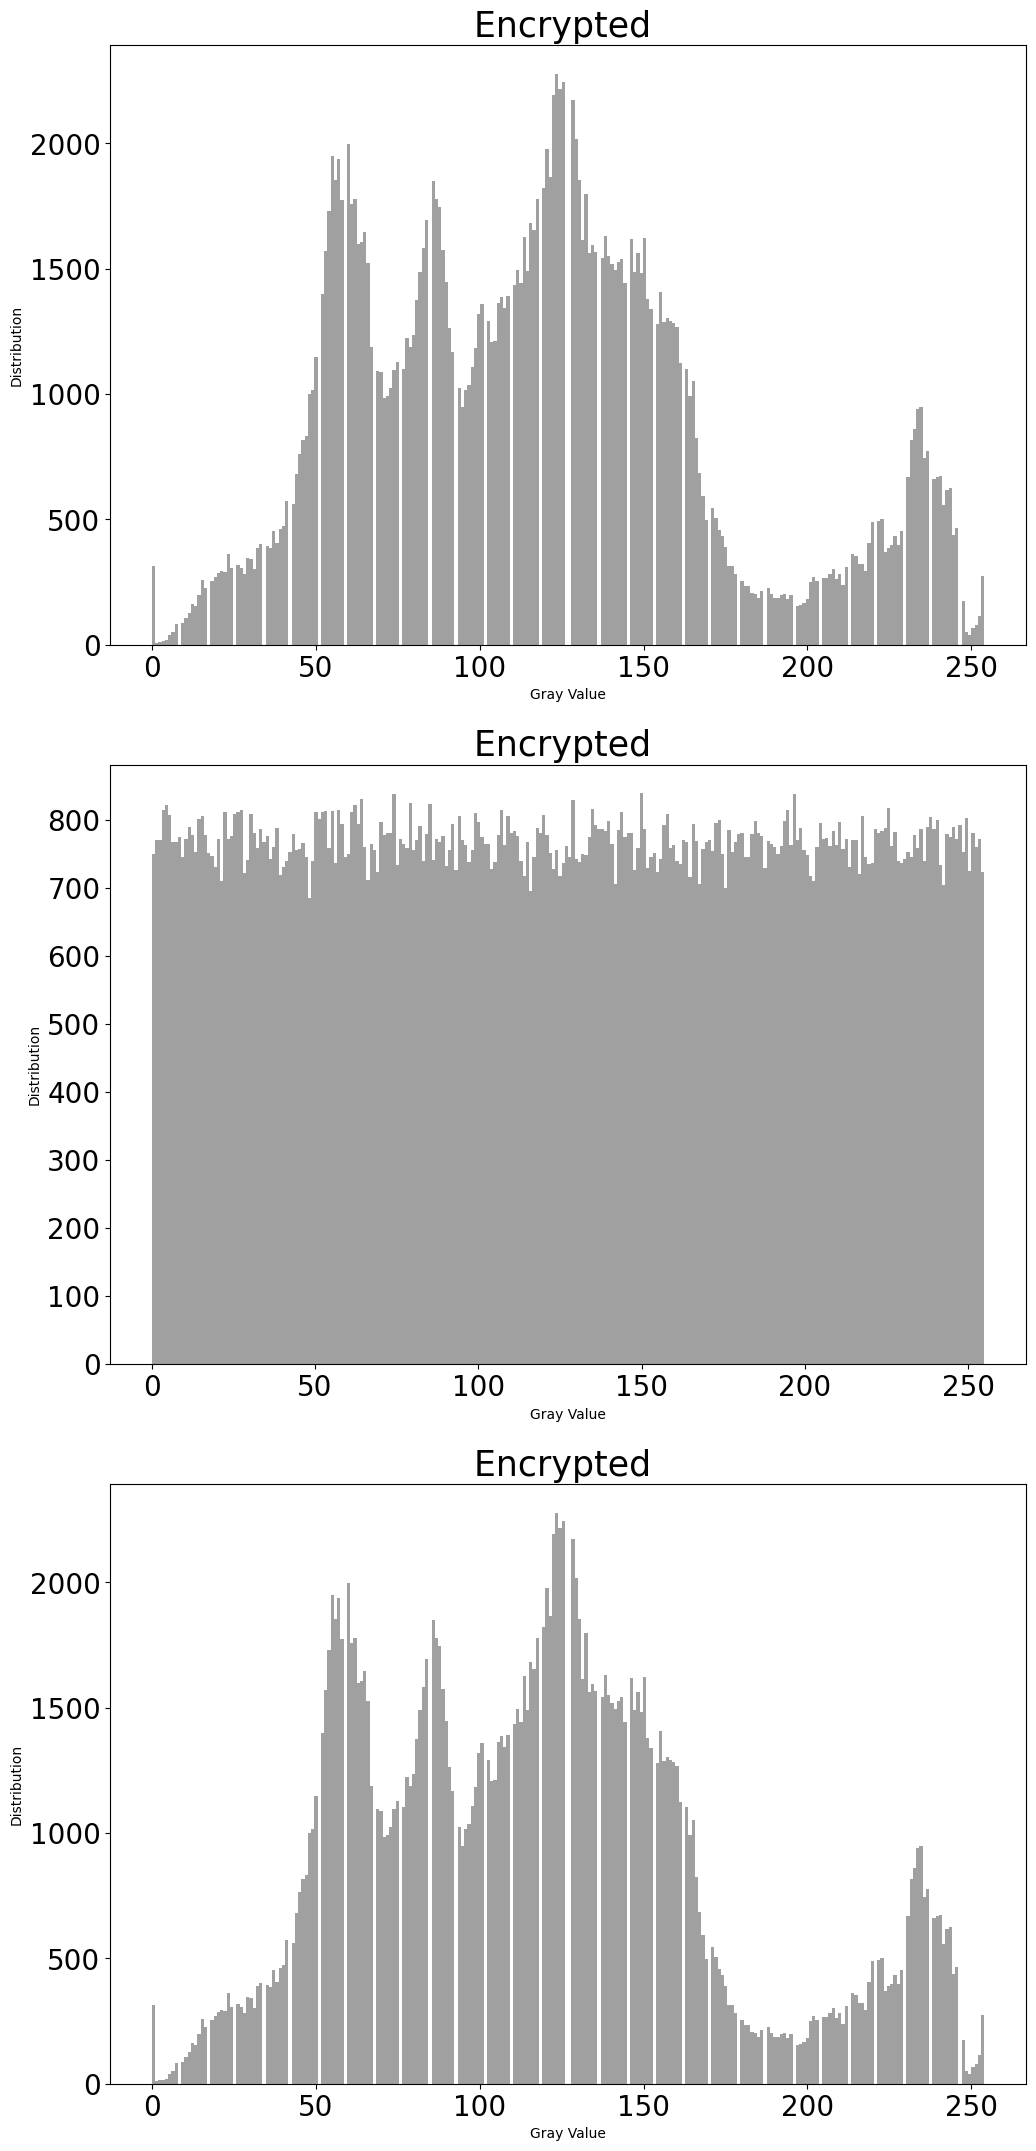

In [17]:

img = cv2.imread('elaine.jpg')

w,h,d = img.shape 
encImg = doColorEnc(img,originalKey)
cv2.imwrite("encImg.jpg", encImg)

decImg = doColorDec(encImg,originalKey);
cv2.imwrite("decImg.jpg", decImg)

# doCipherTextAttack(img,w,h)
# doDifferntialTest(w,h,d)


# decWithoutKey = decWithoutKeyTest1(encImg)
# cv2.imwrite('dec_write_'+str(mres)+'.jpg',decWithoutKey)


# imgTested = testWithPlainAndCipher(img,encImg)




listOfIm = [img,encImg, decImg]
histogram(listOfIm)

# autumnSimilarImageTest()

print('Correlation of encrypted',corr_coefficient(img.flatten(),encImg.flatten(),w*h))
print('Distance Coefficient of encrypted',distanceCorrelation(img.flatten(),encImg.flatten()))

print('Correlation of decrypted',corr_coefficient(img.flatten(),decImg.flatten(),w*h))
print('Distance Coefficient of decrypted',distanceCorrelation(img.flatten(),decImg.flatten()))

# # correlation(img,encImg)

# w,h,d = img.shape
# encImg = encImg.reshape((w,h*d))
# img = img.reshape((w,h*d))
# decImg = decImg.reshape((w,h*d))
# # # # Remember to remove # on reshape for doColorEnc final


print(shannonEntropy(img))
print(shannonEntropy(encImg))
print(shannonEntropy(decImg))



